# Monte Carlo法以及MCMC
## 简单的Monte Carlo
令$\left(x_1,x_2\right)\in\left[-1,1\right]\times\left[-1,1\right]$，以及：$$h\left(x_1,x_2\right)=\frac{1}{2}\exp\left\{ -90\left(x_1-0.5\right)^{2}-45\left(x_2+0.1\right)^{2}\right\} $$
为了计算：$$I=\int h\left(x\right)dx$$
我们可以先在$\left[-1,1\right]\times\left[-1,1\right]$的均匀分布中进行抽样，其密度函数为$f\left(x\right)=\frac{1}{4}$，从而数值积分为：$$\hat{I}=\frac{1}{N}\sum_{i=1}^{N}\frac{h\left(x_{i}\right)}{f\left(x_{i}\right)}=\frac{4}{N}\sum_{i=1}^{N}h\left(x_{i}\right)$$

In [1]:
import numpy as np
from numpy import random as nprd

##设定参数
M=10000
h=lambda x: 0.5*np.exp(-90*(x[0]-0.5)**2-45*(x[1]+0.1)**2)

##抽样
x=[(nprd.random()*2-1,nprd.random()*2-1) for i in range(M)]

##计算h(x)
sample=list(map(h,x))
integral=4*np.mean(sample)
se=4*np.std(sample)/np.sqrt(M)
subsample_001=list(filter(lambda x: x>0.01, sample))
print("Intgral=",integral)
print("s.e. of Integral=",se)
print("95% C.I.:",integral-1.96*se,"~",integral+1.96*se)
print("Ratio of >0.01 samples:",len(subsample_001)/M)

Intgral= 0.0251102273449
s.e. of Integral= 0.00152384105255
95% C.I.: 0.0221234988819 ~ 0.0280969558079
Ratio of >0.01 samples: 0.0505


## 重要性抽样
### 算法1
首先，我们可以使用一个工具分布，比如$x_1\sim N\left(0.5,\frac{1}{180}\right)$,$x_2\sim N\left(-0.1,\frac{1}{90}\right)$进行抽样，假设该联合分布函数为$m\left(x_1,x_2\right)$，然后计算$$\hat{I}=\frac{1}{N}\sum_{i=1}^{N}h\left(x_{i}\right)\frac{\pi\left(x_{i}\right)}{m\left(x_{i}\right)}$$

In [2]:
import numpy as np
from numpy import random as nprd

##设定参数
M =10000
h1=lambda x: 0.5*np.exp(-90*(x[0]-0.5)**2-45*(x[1]+0.1)**2)
domain=lambda x:(x[0]>=-1)*(x[1]>=-1)*(x[0]<=1)*(x[1]<=1)
pai=lambda x: 1/4*domain(x)
h=lambda x: 4*h1(x)
mu1=0.5
mu2=-0.1
sigma1=np.sqrt(1/180)
sigma2=np.sqrt(1/90)
m=lambda x: 1/(2*np.pi*sigma1*sigma2)* \
    np.exp(-1*(x[0]-mu1)**2/(2*sigma1**2)\
           -(x[1]-mu2)**2/(2*sigma2**2))

#从m(x)中采样
x=[(nprd.normal(mu1,sigma1),nprd.normal(mu2,sigma2))\
   for i in range(M)]

## 计算积分
H=list(map(lambda x:h(x)*pai(x)/m(x),x))
integral=np.mean(H)
se=np.std(H)/np.sqrt(M)
print("Intgral=",integral)
print("s.e. of Integral=",se)
print("95% C.I.:",integral-1.96*se,"~",integral+1.96*se)

Intgral= 0.0246826829898
s.e. of Integral= 7.79383284694e-20
95% C.I.: 0.0246826829898 ~ 0.0246826829898


### 算法2
在重要性抽样的第二种算法中，为了计算第一部分的积分，我们首先使用拒绝采样法，从$$g\left(x_1,x_2\right)\propto\exp\left\{ -90\left(x_1-0.5\right)^{2}-45\left(x_2+0.1\right)^{2}\right\} \cdot1\left\{ -1\leq x_1\leq1\right\} \cdot1\left\{ -1\leq x_2\leq1\right\}$$
中进行抽样，然后使用公式：$$\check{I}=\frac{\sum_{i=1}^{N}\frac{h\left(x_{1i},x_{2i}\right)}{\left|h\left(x_{1i},x_{2i}\right)\right|}}{\sum_{i=1}^{N}\frac{1}{\left|h\left(x_{1i},x_{2i}\right)\right|}}=\frac{\sum_{i=1}^{N}\frac{h_{1}\left(x_{1i},x_{2i}\right)}{\left|h_{1}\left(x_{1i},x_{2i}\right)\right|}}{\sum_{i=1}^{N}\frac{1}{\left|4h_{1}\left(x_{1i},x_{2i}\right)\right|}}=\frac{4}{\frac{1}{N}\sum_{i=1}^{N}\frac{1}{\left|h_{1}\left(x_{1i},x_{2i}\right)\right|}}$$
计算该积分。（详细推导过程见讲义，注意该方法是错的。）

In [3]:
import numpy as np
from numpy import random as nprd

##设定参数
M =10000
h1=lambda x: 0.5*np.exp(-90*(x[0]-0.5)**2-45*(x[1]+0.1)**2)
domain=lambda x:(x[0]>=-1)*(x[1]>=-1)*(x[0]<=1)*(x[1]<=1)
pai=lambda x: 1/4*domain(x)
h=lambda x: 4*h1(x)
l=lambda x:np.exp(-90*(x[0]-0.5)**2-45*(x[1]+0.1)**2)*domain(x)

##拒绝采样法的参数
mu1=0.5
mu2=-0.1
sigma1=np.sqrt(1/180)
sigma2=np.sqrt(1/90)
m=lambda x: 1/(2*np.pi*sigma1*sigma2)* \
    np.exp(-1*(x[0]-mu1)**2/(2*sigma1**2)\
           -(x[1]-mu2)**2/(2*sigma2**2))
x_star=mu1
y_star=mu2
R=l((x_star,y_star))/m((x_star,y_star))
r=lambda x: l(x)/(R*m(x))

##拒绝采样,从g(x)∝l(x)中采样
def sampling(N_samples):
    X=[]
    for i in range(N_samples):
        while True:
            #从m(x)中采样
            x1=nprd.normal(mu1,sigma1)
            x2=nprd.normal(mu2,sigma2)
            #拒绝
            if nprd.uniform()<r((x1,x2)):
                X.append((x1,x2))
                break
    return X

## 计算积分
x=sampling(M)
H=list(map(h,x))
Weight=list(map(lambda x:pai(x)/l(x),x))
HW=[H[i]*Weight[i] for i in range(len(H))]
integral=np.mean(HW)/np.mean(Weight)
print("Intgral=",integral)
                      

Intgral= 0.227401042655


## 独立的Metropolis-Hastings算法
为了计算以上积分，我们将密度函数改写为：$$\int\int\frac{\pi}{90\sqrt{2}}\cdot1\left\{ -1\leq x_1\leq1\right\} \cdot1\left\{ -1\leq x_2\leq1\right\} \cdot f\left(x_1,x_2\right)dx_1dx_2\overset{\Delta}{=}\frac{\pi}{90\sqrt{2}}\int\int h\left(x_1,x_2\right)\cdot\pi\left(x,y\right)dx_1dx_2$$
接下来使用独立的Metropolis-Hastings算法，选取工具密度$$p\left(y|x\right)=\frac{1}{4}1\left\{ -1\leq y_1\leq1\right\} \cdot1\left\{ -1\leq y_2\leq1\right\} $$进行抽样，得到$\left\{ x_{t},t=1,2,...\right\} $，最终计算积分为：$$\hat{I}=\frac{\pi}{90\sqrt{2}}\frac{1}{M}\sum_{t=1}^{M}h\left(x_{1t},x_{2t}\right)$$

Intgral1= 0.0246826829898
Intgral2= 0.00281356876305


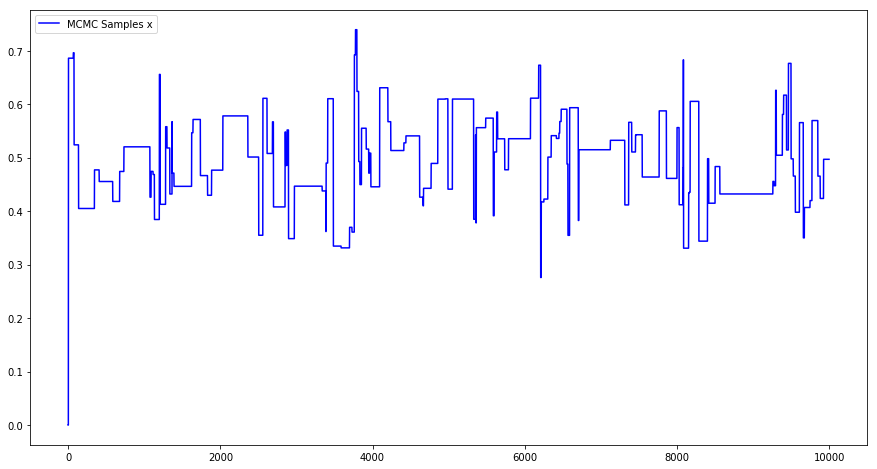

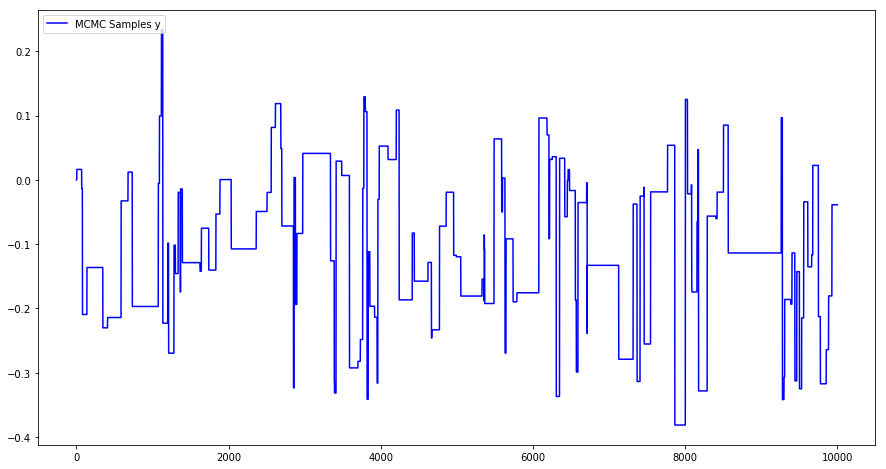

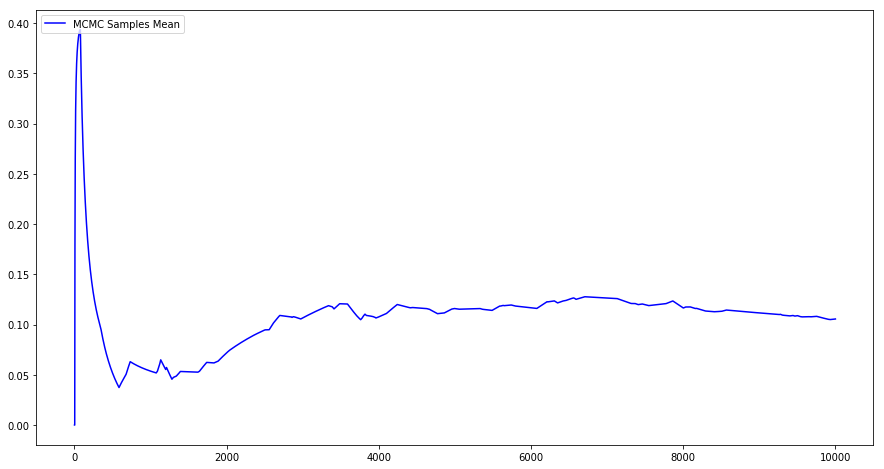

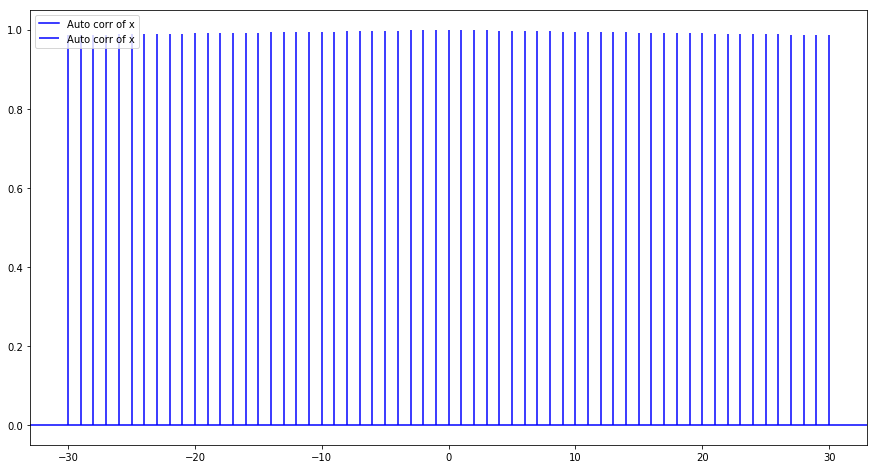

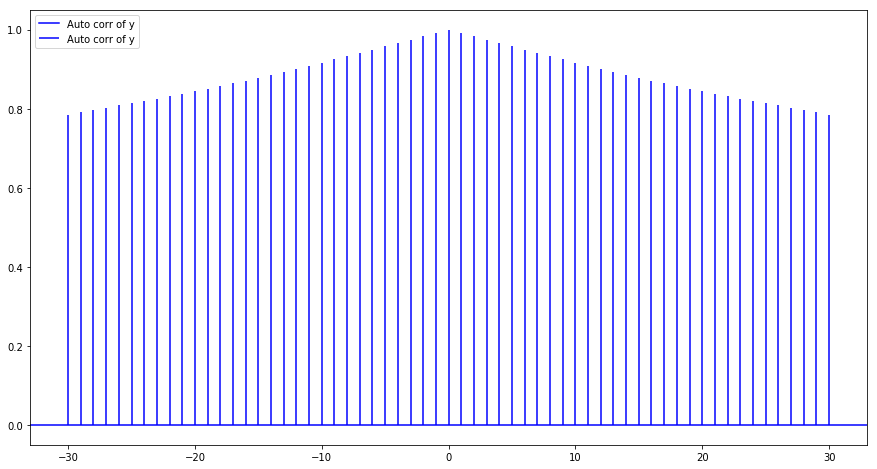

In [4]:
import numpy as np
from numpy import random as nprd

##设定参数
M =10000
pai_cons=90*np.sqrt(2)/(2*np.pi)
pai=lambda x: pai_cons* \
    np.exp(-90*(x[0]-0.5)**2-45*(x[1]+0.1)**2)
domain=lambda x:(x[0]>=-1)*(x[1]>=-1)*(x[0]<=1)*(x[1]<=1)
q=lambda y: 1/(2*np.pi)*np.exp(-1*y[0]**2/2-y[1]**2/2)
h=lambda x: domain(x)
h2=lambda x: np.sin(x[0])**2+np.log(abs(1+x[1]))
#从均匀分布中采样
def sample_q():
    return (nprd.normal(),nprd.normal())


##独立的MCMC算法，输入：
##    N_samples  : 抽样次数
##      pai(x)   : 目标密度函数
##      q(y)     : 工具密度函数
##   q_sampler   : 给定x，从q中抽样的函数
##      x0       : 初始值
def MH_independent(N_samples, pai, q, q_sampler, x0):
    X=[]
    x=x0
    for i in range(N_samples):
        y=q_sampler()
        rho=min(1,pai(y)*q(x)/(pai(x)*q(y)))
        if nprd.uniform()<rho:
            X.append(y)
            x=y
        else:
            X.append(x)
    return X

## 计算积分
x=MH_independent(M, pai, q, sample_q, (0,0))
## 第一个积分
H=list(map(h,x))
## 取h后面80%的样本
subH=H[int(M*0.2):]
integral=np.pi/(90*np.sqrt(2))*np.mean(subH)
print("Intgral1=",integral)
## 第二个积分
H2=list(map(h2,x))
subH2=H2[int(M*0.2):]
integral2=np.pi/(90*np.sqrt(2))*np.mean(subH2)
print("Intgral2=",integral2)

## 诊断图
import matplotlib.pyplot as plt 
%matplotlib inline
# 设定图像大小
plt.rcParams['figure.figsize'] = (15.0, 8.0)
index=[i for i in range(len(H))]
x_x=[x[i][0] for i in range(len(H))]
x_y=[x[i][1] for i in range(len(H))]
plt.plot(index,x_x,label=r'MCMC Samples x',color='blue')
plt.legend(loc='upper left', frameon=True)
plt.show() ## 画图
plt.plot(index,x_y,label=r'MCMC Samples y',color='blue')
plt.legend(loc='upper left', frameon=True)
plt.show() ## 画图
average_H2=[np.mean(H2[:i]) for i in range(len(H)) if i!=0]
plt.plot(index[1:],average_H2,label=r'MCMC Samples Mean',color='blue')
plt.legend(loc='upper left', frameon=True)
plt.show() ## 画图
plt.acorr(x_x,label=r'Auto corr of x',color='blue', maxlags=30)
plt.legend(loc='upper left', frameon=True)
plt.show() ## 画图
plt.acorr(x_y,label=r'Auto corr of y',color='blue', maxlags=30)
plt.legend(loc='upper left', frameon=True)
plt.show() ## 画图
                      

## 随机游走的Metropolis-Hastings算法
在这里，我们令$\epsilon_{1,t}\sim N\left(0,0.3^{2}\right)$，$\epsilon_{2,t}\sim N\left(0,0.3^{2}\right)$以及：$$y_{1t}=x_{1t}+\epsilon_{1,t}$$ $$y_{2t}=x_{2t}+\epsilon_{2,t}$$
对马尔可夫链进行更新。

Intgral1= 0.0246826829898
Intgral2= 0.00282311326563


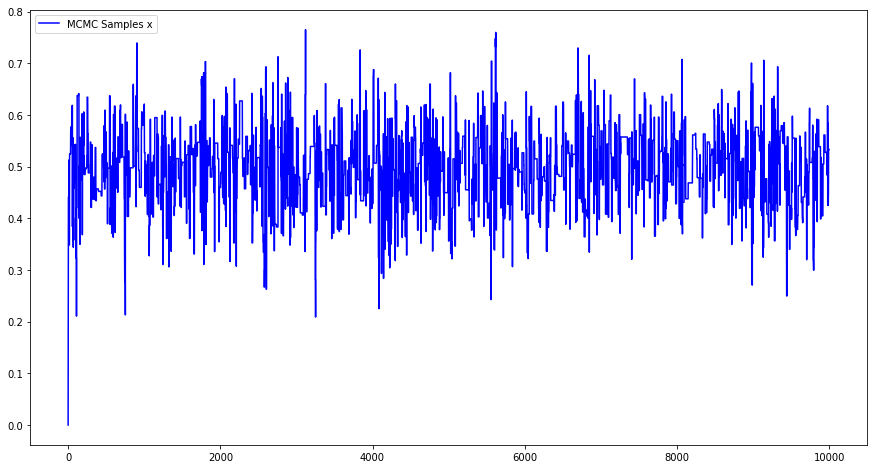

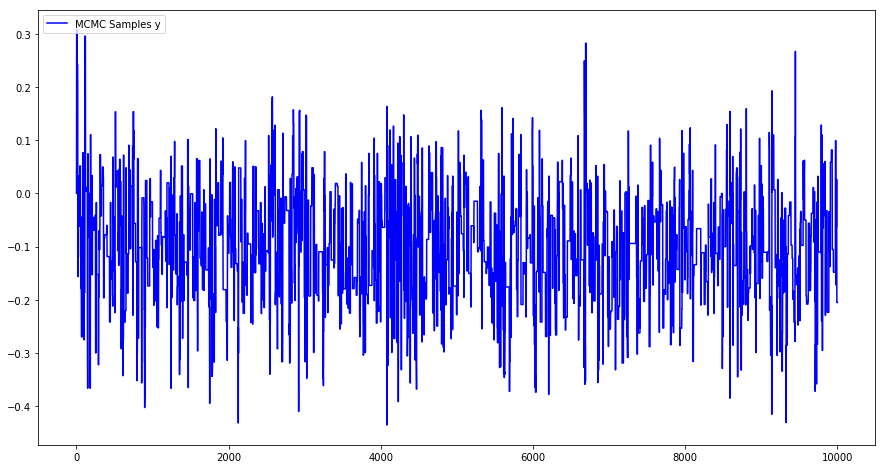

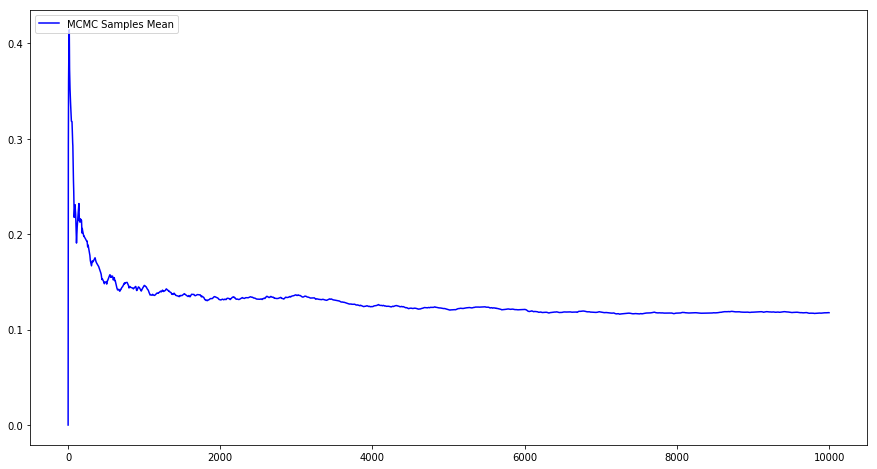

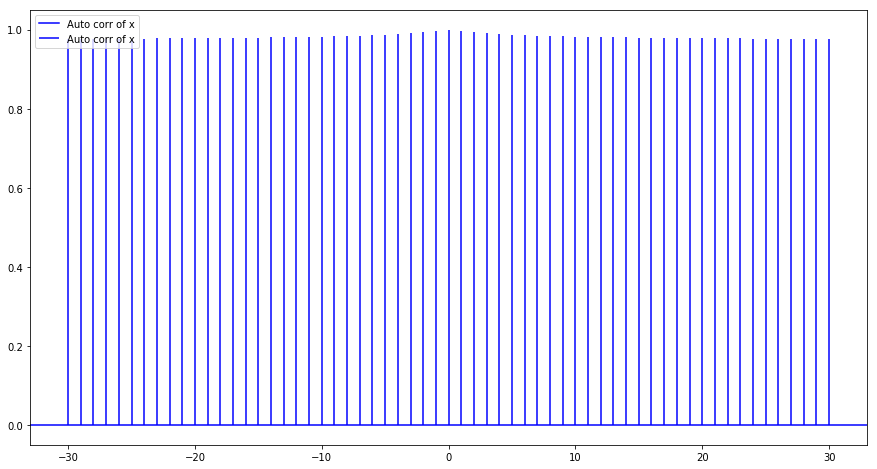

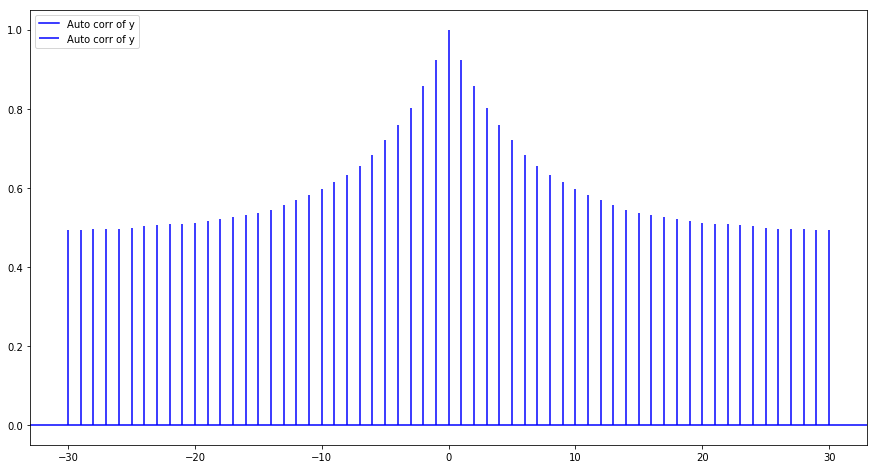

In [5]:
import numpy as np
from numpy import random as nprd

##设定参数
M =10000
pai_cons=90*np.sqrt(2)/(2*np.pi)
pai=lambda x: pai_cons* \
    np.exp(-90*(x[0]-0.5)**2-45*(x[1]+0.1)**2)
domain=lambda x:(x[0]>=-1)*(x[1]>=-1)*(x[0]<=1)*(x[1]<=1)
h=lambda x: domain(x)
h2=lambda x: np.sin(x[0])**2+np.log(abs(1+x[1]))
#从均匀分布中采样
def sample_q(x):
    return (x[0]+0.3*nprd.normal(),x[1]+0.3*nprd.normal())


##独立的MCMC算法，输入：
##    N_samples  : 抽样次数
##      pai(x)   : 目标密度函数
##   q_sampler(x): 给定x，从q中抽样的函数
##      x0       : 初始值
def MH_RW(N_samples, pai, q_sampler, x0):
    X=[]
    x=x0
    for i in range(N_samples):
        y=q_sampler(x)
        rho=min(1,pai(y)/pai(x))
        if nprd.uniform()<rho:
            X.append(y)
            x=y
        else:
            X.append(x)
    return X

## 计算积分
x=MH_RW(M, pai, sample_q, (0,0))
## 第一个积分
H=list(map(h,x))
## 取h后面80%的样本
subH=H[int(M*0.2):]
integral=np.pi/(90*np.sqrt(2))*np.mean(subH)
print("Intgral1=",integral)
## 第二个积分
H2=list(map(h2,x))
subH2=H2[int(M*0.2):]
integral2=np.pi/(90*np.sqrt(2))*np.mean(subH2)
print("Intgral2=",integral2)

## 诊断图
import matplotlib.pyplot as plt 
%matplotlib inline
# 设定图像大小
plt.rcParams['figure.figsize'] = (15.0, 8.0)
index=[i for i in range(len(H))]
x_x=[x[i][0] for i in range(len(H))]
x_y=[x[i][1] for i in range(len(H))]
plt.plot(index,x_x,label=r'MCMC Samples x',color='blue')
plt.legend(loc='upper left', frameon=True)
plt.show() ## 画图
plt.plot(index,x_y,label=r'MCMC Samples y',color='blue')
plt.legend(loc='upper left', frameon=True)
plt.show() ## 画图
average_H2=[np.mean(H2[:i]) for i in range(len(H)) if i!=0]
plt.plot(index[1:],average_H2,label=r'MCMC Samples Mean',color='blue')
plt.legend(loc='upper left', frameon=True)
plt.show() ## 画图
plt.acorr(x_x,label=r'Auto corr of x',color='blue', maxlags=30)
plt.legend(loc='upper left', frameon=True)
plt.show() ## 画图
plt.acorr(x_y,label=r'Auto corr of y',color='blue', maxlags=30)
plt.legend(loc='upper left', frameon=True)
plt.show() ## 画图